In [116]:
import pandas as pd
import numpy as np
import pmdarima as pm
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model

from warnings import filterwarnings
filterwarnings("ignore")
%matplotlib inline


In [117]:
def plot_acf_pacf(series, lag):
    plt.rcParams["figure.figsize"] = 18, 5

    fig, axes = plt.subplots(1, 2)

    sgt.plot_acf(series, ax=axes[0], lags=lag)
    sgt.plot_pacf(series, ax=axes[1], lags=lag, method="ywm")
    plt.show()


def d_determination(series, crit=5):
    crit = str(crit) + "%"
    d = 1
    while True:
        series_new = series.diff(d).dropna()
        test = adfuller(series_new)
        if test[0] < test[4][crit]:
            return d, series_new
        d += 1


def grafics(data, test_df, model_fit):
    pred_df = pd.DataFrame(index=data.index)

    pred_df["model_preds"] = model_fit.predict(
        start=test_df.index[0], end=test_df.index[-1])
    pred_df["GDP"] = data["GDP"]
    forecast = model_fit.get_forecast(len(test_df.index))
    forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

    pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower GDP"]
    pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper GDP"]

    plt.rcParams["figure.figsize"] = 18, 12

    plt.subplot(2, 1, 1)
    plt.plot(pred_df["GDP"], color="blue", label="Actuals", alpha=0.4)

    plt.plot(
        pred_df.loc[test_df.index]["model_preds"],
        color="red",
        linestyle="-",
        label="Out of Sample Fit",
    )

    plt.plot(
        pred_df.loc[test_df.index]["model_preds_lower"],
        color="green",
        linestyle="--",
        label="Confidence Intervals (95%)",
        alpha=0.4,
    )

    plt.plot(
        pred_df.loc[test_df.index]["model_preds_upper"],
        color="green",
        linestyle="--",
        alpha=0.4,
    )

    plt.title("Full Model Fit", size=24)
    plt.legend()

    plt.subplot(2, 2, 3)

    plt.plot(pred_df.loc[test_df.index]["GDP"],
             color="blue", label="Actuals", alpha=0.6)

    plt.plot(
        pred_df.loc[test_df.index]["model_preds"],
        color="red",
        linestyle="-",
        label="Out of Sample Fit",
        alpha=0.6,
    )

    plt.plot(
        pred_df.loc[test_df.index]["model_preds_lower"],
        color="green",
        linestyle="--",
        label="Confidence Intervals (95%)",
        alpha=0.6,
    )

    plt.plot(
        pred_df.loc[test_df.index]["model_preds_upper"],
        color="green",
        linestyle="--",
        alpha=0.6,
    )

    plt.title("Out of Sample Fit", size=24)
    plt.legend()

    plt.show()


In [118]:
data = pd.read_csv("data/ghana_gdp.csv",
                   parse_dates=["GDP (current US$)"], index_col=["year"])
data.rename(columns={'GDP (current US$)': 'GDP'}, inplace=True)
data["GDP"] = data["GDP"].astype(float)
data.index = pd.to_datetime(data.index)
data.head()


,GDP
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


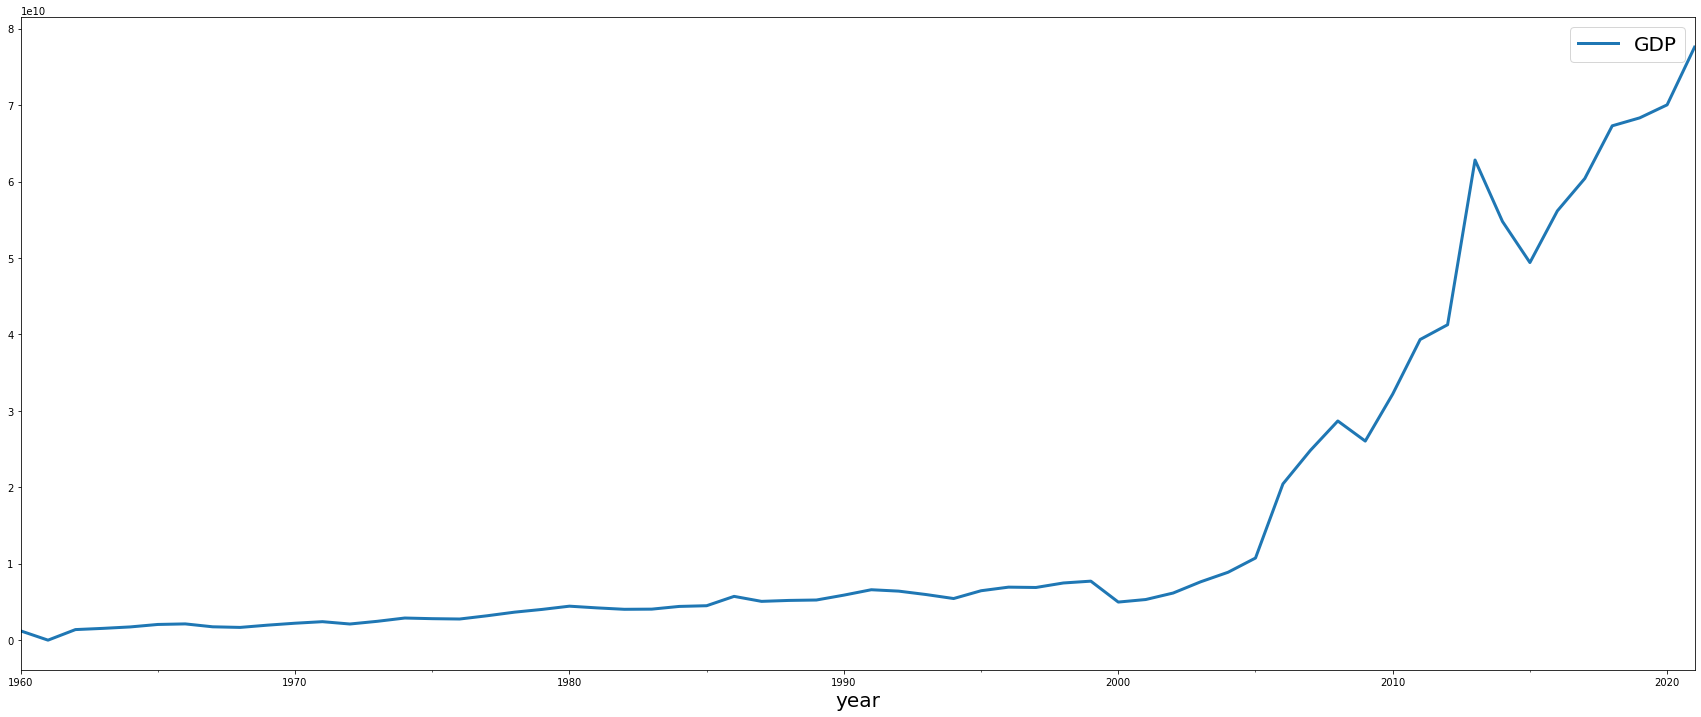

In [119]:
plt.rcParams["figure.figsize"] = 30, 12
plt.rcParams["font.size"] = 20
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["lines.linewidth"] = 3

data.plot()
plt.show()


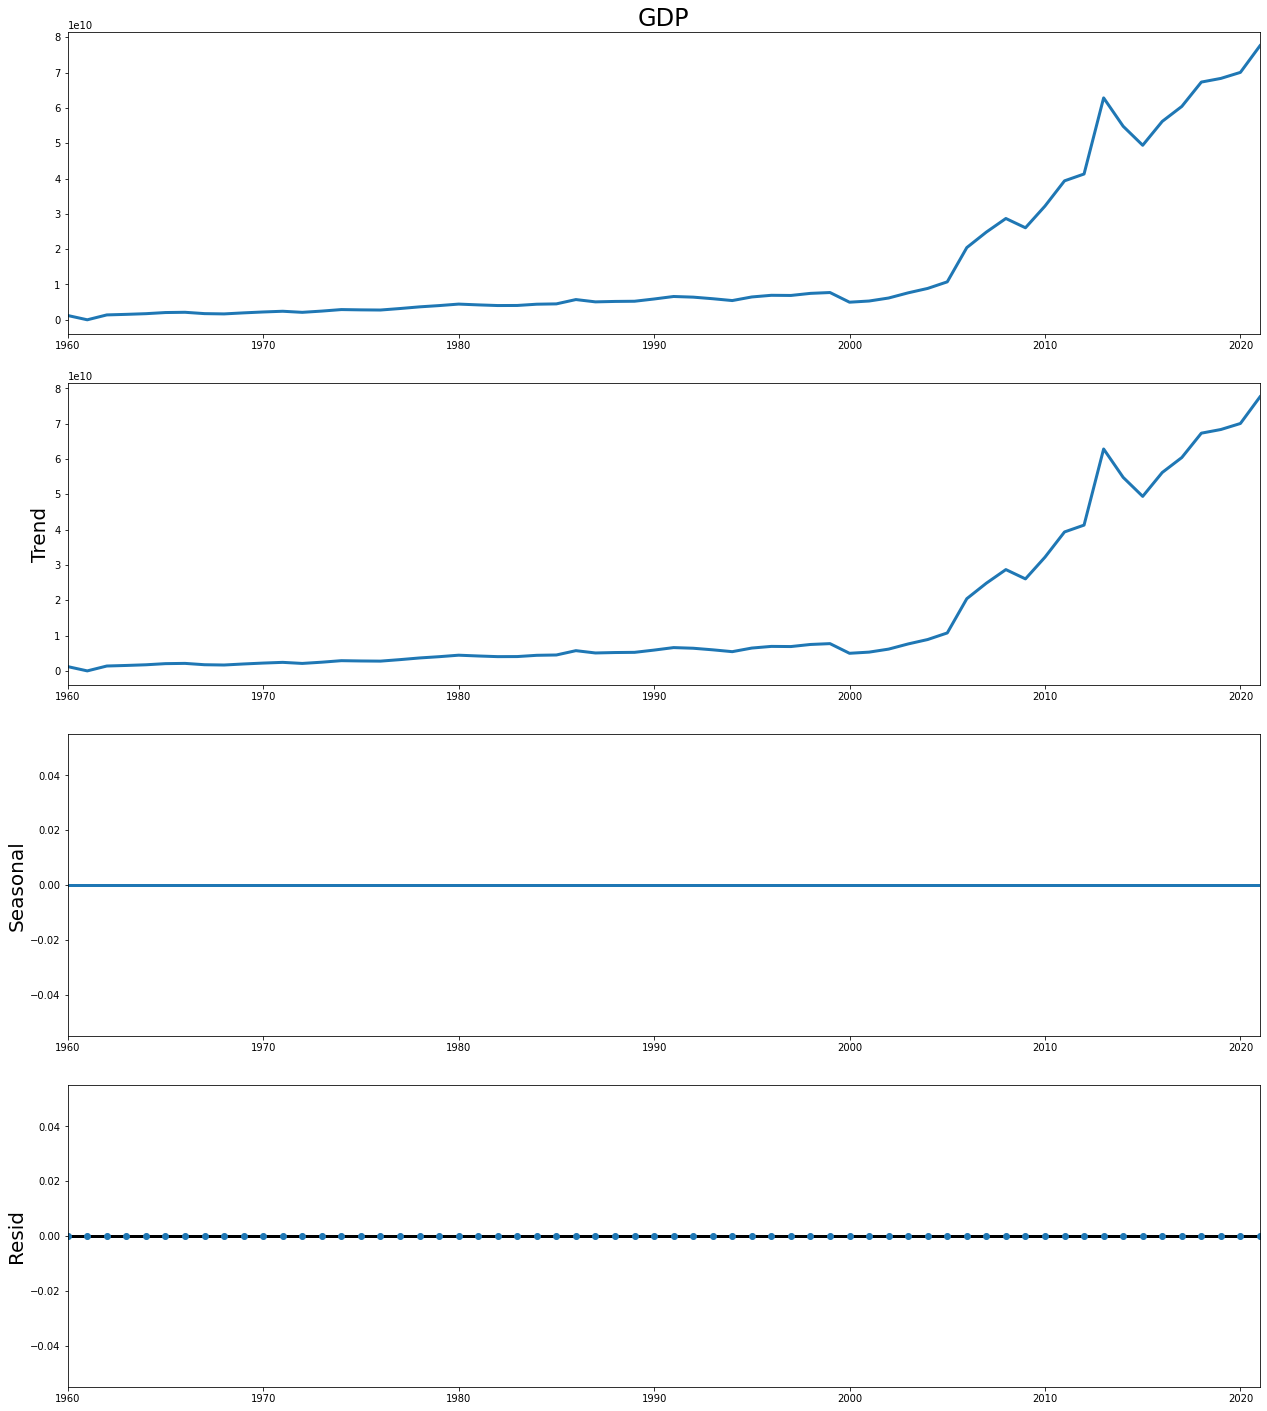

In [120]:
plt.rcParams["figure.figsize"] = 18, 20

result = seasonal_decompose(data["GDP"])
result.plot()
plt.show()


In [121]:
train_df = data.iloc[:-3]
test_df = data.iloc[-3:]
train_df.shape, test_df.shape


((59, 1), (3, 1))

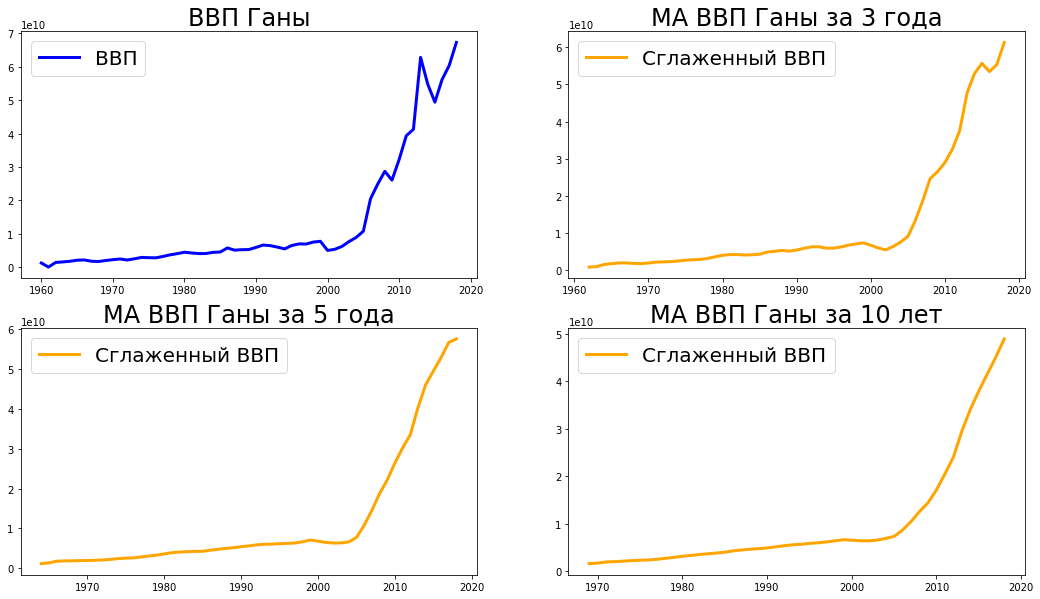

In [122]:
plt.rcParams["figure.figsize"] = 18, 10

fig, ax = plt.subplots(2, 2)

ax[0, 0].plot(train_df.GDP, color="blue", label="ВВП")
ax[0, 0].set_title("ВВП Ганы", size=24)
ax[0, 0].legend()

# Окно в месяц (Window = 3)
ax[0, 1].plot(
    train_df.GDP.rolling(window=3).mean(),
    color="orange",
    label="Сглаженный ВВП",
)

ax[0, 1].set_title("MA ВВП Ганы за 3 года", size=24)
ax[0, 1].legend()

# Окно в месяц (Window = 5)
ax[1, 0].plot(
    train_df.GDP.rolling(window=5).mean(),
    color="orange",
    label="Сглаженный ВВП",
)

ax[1, 0].set_title("MA ВВП Ганы за 5 года", size=24)
ax[1, 0].legend()

# Окно в год (Window = 10)
ax[1, 1].plot(
    train_df.GDP.rolling(window=10).mean(),
    color="orange",
    label="Сглаженный ВВП",
)

ax[1, 1].set_title("MA ВВП Ганы за 10 лет", size=24)
ax[1, 1].legend()

plt.show()


Чем меньше окно сдвига MA, тем больше модель реагирует на выборсы. Оптимальнее использовать не очень маленькие и не очень большие значения окна, описываающие изменение показателя без "скачков" и "рывков", например, 10.

In [123]:
test = adfuller(train_df.GDP)
print("adf: ", test[0])
print("p-value: ", test[1])
print("Critical values: ", test[4])
if test[0] > test[4]["5%"]:
    print("ряд нестационарен")
else:
    print("ряд стационарен")


adf:  0.6529066974885349
p-value:  0.9888496277665572
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
ряд нестационарен


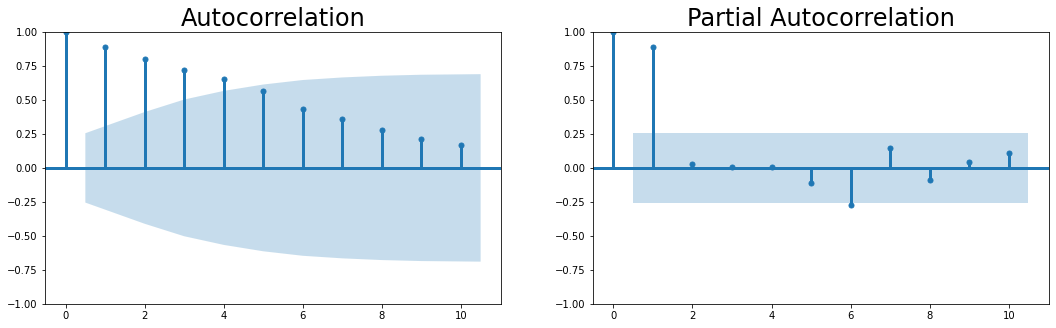

In [124]:
plot_acf_pacf(train_df.GDP, 10)


In [125]:
# Определим параметр d
d, ser = d_determination(train_df.GDP)
print('Параметр d равен {}.'.format(d))


Параметр d равен 2.


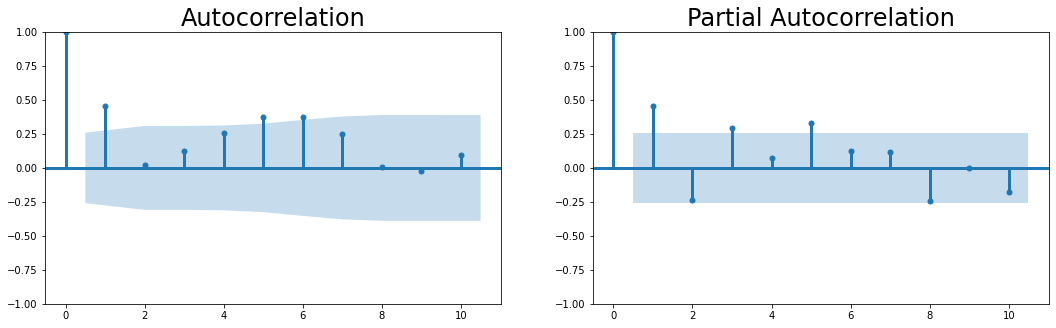

In [126]:
plot_acf_pacf(ser, 10)


Судя по карелограмме, p=3, q=6. 
Так как ряд не стационарен будем использовать модель ARIMA.

In [127]:
arima_model = ARIMA(train_df.GDP, order=(3, 2, 6))
arima_model_fit_1 = arima_model.fit()
arima_model_fit_1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    GDP   No. Observations:                   59
Model:                 ARIMA(3, 2, 6)   Log Likelihood               -1332.974
Date:                Tue, 23 May 2023   AIC                           2685.948
Time:                        07:13:44   BIC                           2706.379
Sample:                    01-01-1960   HQIC                          2693.888
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4055      0.368      1.102      0.270      -0.316       1.127
ar.L2         -0.4217      0.338     -1.248      0.212      -1.084       0.240
ar.L3         -0.2291      0.549     -0.417      0.677      -1.306       0.848
ma.L1         -1.5217      0.470     -3.237      0.001      -2.443      -0.600
ma.L2          0.9032      0.981      0.921      0.357      -1.019       2.825
ma.L3          0.2629      1.301      0.202      0.840      -2.288       2.814
ma.L4         -1.1561      1.069     -1.082      0.279      -3.251       0.939
ma.L5          1.3181      0.556      2.373      0.018       0.229       2.407
ma.L6         -0.5983      0.292     -2.050      0.040      -1.170      -0.026
sigma2      1.999e+19   1.39e-18   1.44e+37      0.000       2e+19       2e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                74.15
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):             123.37   Skew:                             1.26
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.12e+51. Standard errors may be unstable.
"""

In [128]:
smodel = pm.auto_arima(
    train_df.GDP,
    start_p=1,
    d=2,
    start_q=1,
    max_p=10,
    max_q=10,
    test="adf",
    error_action="ignore",
    trace=True,
)

smodel.summary()


Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2684.416, Time=0.08 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2719.959, Time=0.05 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=2704.667, Time=0.05 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=2683.622, Time=0.05 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=2681.414, Time=0.07 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=2680.988, Time=0.18 sec
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=2680.765, Time=0.21 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=2686.992, Time=0.07 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=2682.648, Time=0.34 sec
 ARIMA(1,2,4)(0,0,0)[0]             : AIC=2682.800, Time=0.21 sec
 ARIMA(0,2,4)(0,0,0)[0]             : AIC=2688.234, Time=0.16 sec
 ARIMA(2,2,4)(0,0,0)[0]             : AIC=2683.409, Time=0.33 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=2686.657, Time=0.27 sec

Best model:  ARIMA(1,2,3)(0,0,0)[0]  

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(1, 2, 3)   Log Likelihood               -1335.382
Date:                Tue, 23 May 2023   AIC                           2680.765
Time:                        07:13:46   BIC                           2690.980
Sample:                    01-01-1960   HQIC                          2684.735
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5682      0.163     -3.487      0.000      -0.888      -0.249
ma.L1         -0.4241      0.235     -1.803      0.071      -0.885       0.037
ma.L2         -0.8256      0.169     -4.886      0.000      -1.157      -0.494
ma.L3          0.5193      0.137      3.790      0.000       0.251       0.788
sigma2      1.868e+19   8.55e-21   2.18e+39      0.000    1.87e+19    1.87e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               173.00
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):             141.34   Skew:                             1.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.43e+55. Standard errors may be unstable.
"""

In [129]:
arima_model = ARIMA(train_df.GDP.dropna(), order=(1, 2, 3))
arima_model_fit_2 = arima_model.fit()
arima_model_fit_2.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    GDP   No. Observations:                   59
Model:                 ARIMA(1, 2, 3)   Log Likelihood               -1335.382
Date:                Tue, 23 May 2023   AIC                           2680.765
Time:                        07:13:46   BIC                           2690.980
Sample:                    01-01-1960   HQIC                          2684.735
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5682      0.163     -3.487      0.000      -0.888      -0.249
ma.L1         -0.4241      0.235     -1.803      0.071      -0.885       0.037
ma.L2         -0.8256      0.169     -4.886      0.000      -1.157      -0.494
ma.L3          0.5193      0.137      3.790      0.000       0.251       0.788
sigma2      1.868e+19   8.55e-21   2.18e+39      0.000    1.87e+19    1.87e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               173.00
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):             141.34   Skew:                             1.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.43e+55. Standard errors may be unstable.
"""

In [130]:
arima_model = ARIMA(train_df.GDP.dropna(), order=(4, 2, 4))
arima_model_fit_3 = arima_model.fit()
arima_model_fit_3.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    GDP   No. Observations:                   59
Model:                 ARIMA(4, 2, 4)   Log Likelihood               -1328.619
Date:                Tue, 23 May 2023   AIC                           2675.237
Time:                        07:13:47   BIC                           2693.625
Sample:                    01-01-1960   HQIC                          2682.383
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2100      0.547     -0.384      0.701      -1.282       0.862
ar.L2          0.0482      0.273      0.177      0.860      -0.487       0.583
ar.L3         -0.4186      0.280     -1.494      0.135      -0.968       0.131
ar.L4         -0.4163      0.185     -2.244      0.025      -0.780      -0.053
ma.L1         -0.8361      0.544     -1.537      0.124      -1.902       0.230
ma.L2         -0.4553      0.446     -1.022      0.307      -1.328       0.418
ma.L3          1.0606      0.598      1.773      0.076      -0.112       2.233
ma.L4         -0.2945      0.589     -0.500      0.617      -1.450       0.861
sigma2      1.246e+19   8.39e-20   1.48e+38      0.000    1.25e+19    1.25e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                78.69
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):             131.86   Skew:                             1.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.56e+54. Standard errors may be unstable.
"""

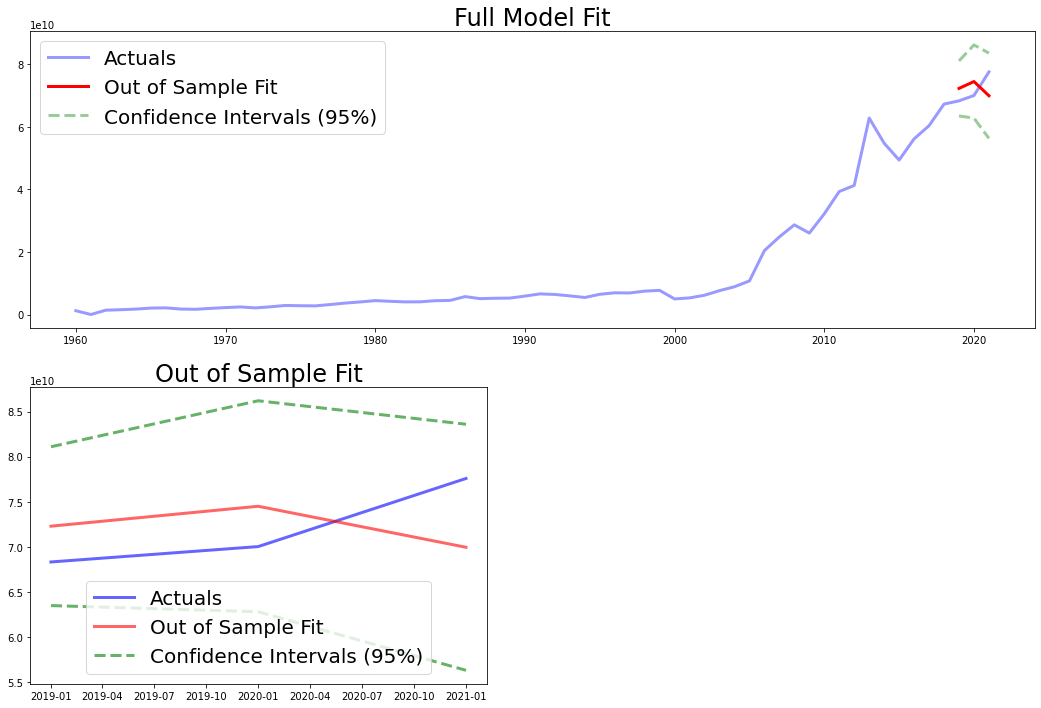

In [131]:
# Строим графики предсказания на основе подобранных по карелограмме параметров
grafics(data, test_df, arima_model_fit_1)


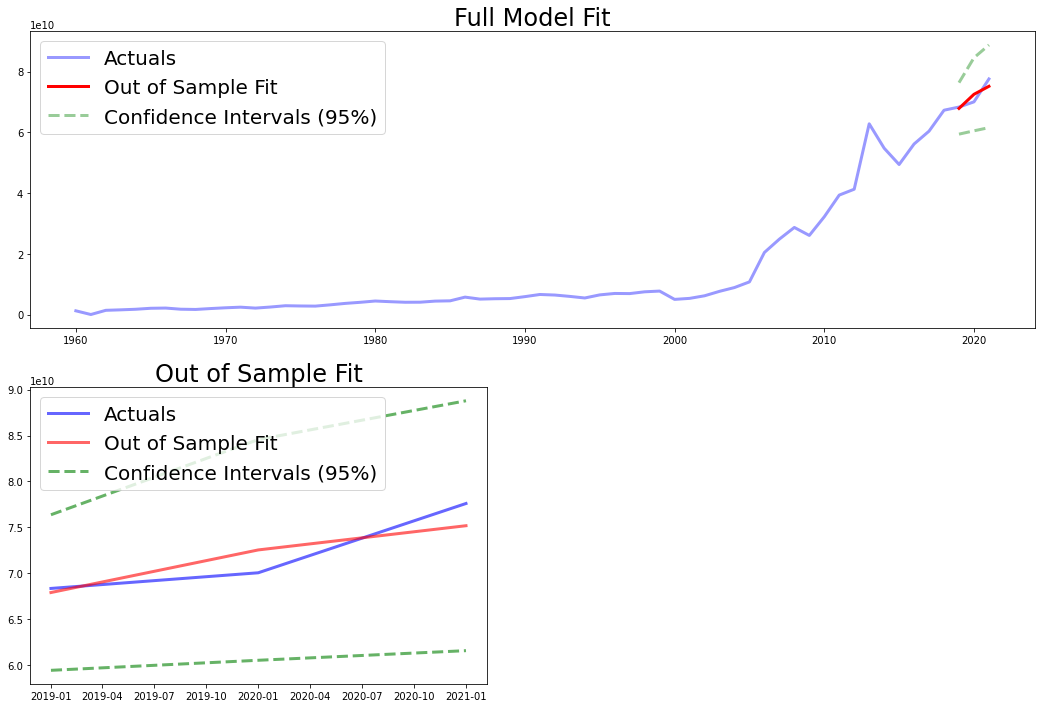

In [132]:
# Строим графики предсказания на основе оптимальных параметров подобранных с помощью auto_arima
grafics(data, test_df, arima_model_fit_2)


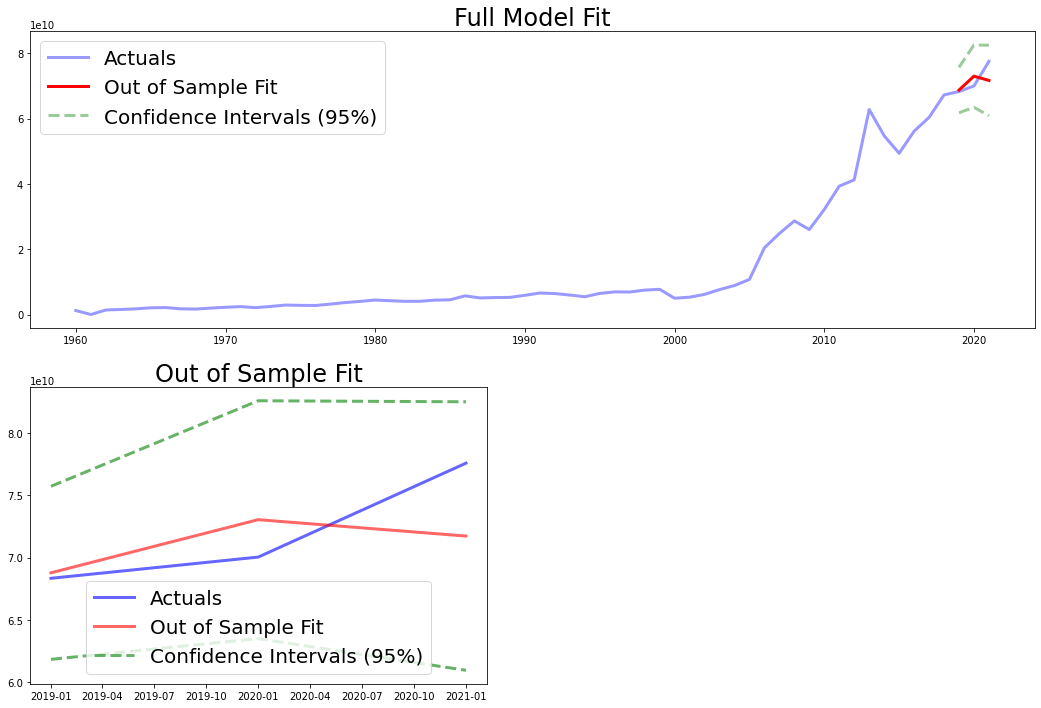

In [133]:
# Строим графики предсказания на основе параметров, давших наименьшее значние AIC методом перебора
grafics(data, test_df, arima_model_fit_3)


Вывод: 
Лучше всех предсказывает модель, выбранная по оптимальным параметрам с помощью auto_arima (1, 2, 3). 
Эта модель лучше "ловит" тренд и ближе к реальным данным.  
Модель, построенная на данных карелограммы, также неплохо справилась, и даже предсказала просадку по ВВП, но в целом чуть хуже описывает реальные изменения ВВП Ганы.

In [134]:
print('Записей до обработки пропусков с помощью метода asfreq: {}.'.format(
    data.shape[0]))
data = data.asfreq(freq='AS')
print('Записей после обработки пропусков с помощью метода asfreq: {}.'.format(
    data.shape[0]))


Записей до обработки пропусков с помощью метода asfreq: 62.
Записей после обработки пропусков с помощью метода asfreq: 62.


Количество записей не изменилось. Пропусков в данных не было. 

In [135]:
data.isna().sum()


GDP    0
dtype: int64

Пропусков со значение NaN нет.

In [136]:
data['GDP'] = data['GDP'].apply(lambda x: np.nan if x == 0 else x)


In [137]:
data.isna().sum()


GDP    1
dtype: int64

После приравнивания значения 0 к пропуску, появился 1 пропуск.

(3184, 1)


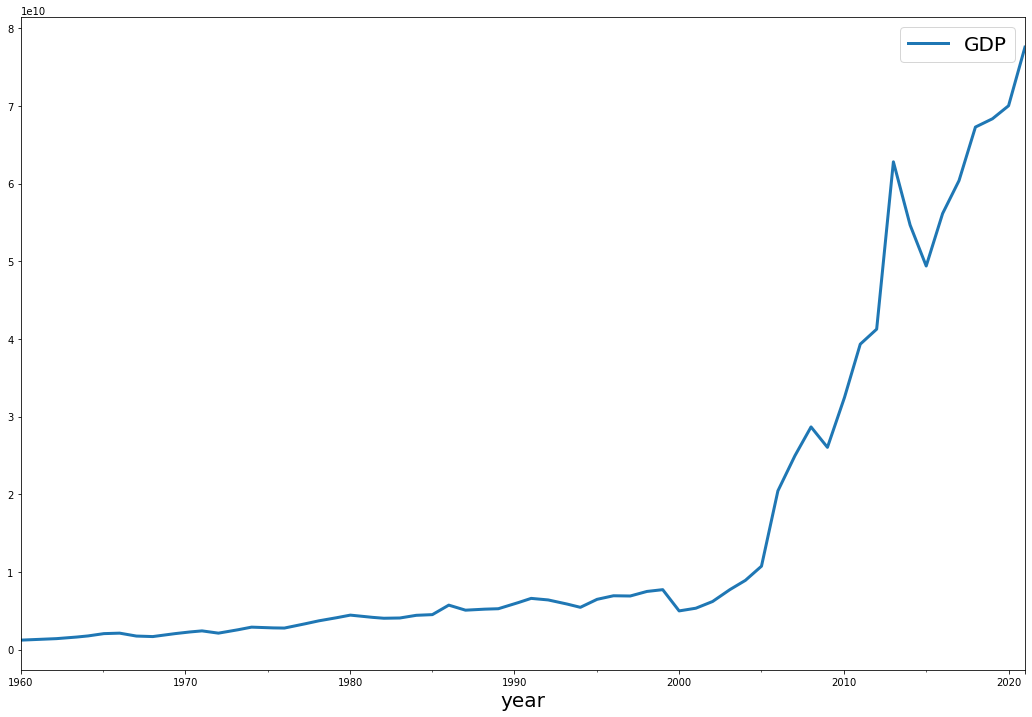

In [138]:
# data['GDP'].resample("w-MON").interpolate(method='linear', inplace=True)

interpolated_data = pd.DataFrame(
    data.GDP.resample("w-MON").mean().interpolate(method='linear'), columns=["GDP"]
)

print(interpolated_data.shape)
interpolated_data.plot()
plt.show()


In [139]:
test = adfuller(train_df.GDP)
print("adf: ", test[0])
print("p-value: ", test[1])
print("Critical values: ", test[4])
if test[0] > test[4]["5%"]:
    print("ряд нестационарен")
else:
    print("ряд стационарен")


adf:  0.6529066974885349
p-value:  0.9888496277665572
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
ряд нестационарен


In [140]:
# Определим параметр d в обновленном датасете
train_df = data.iloc[:-3]
test_df = data.iloc[-3:]

d, ser = d_determination(train_df.GDP)
print('Параметр d равен {}.'.format(d))


Параметр d равен 2.


In [141]:
smodel = pm.auto_arima(
    train_df.GDP.dropna(),
    start_p=1,
    d=2,
    start_q=1,
    max_p=10,
    max_q=10,
    test="adf",
    error_action="ignore",
    trace=True,
)

smodel.summary()


Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2638.413, Time=0.18 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2672.996, Time=0.22 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=2658.194, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=2637.562, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=2635.487, Time=0.05 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=2635.015, Time=0.26 sec
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=2634.793, Time=0.19 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=2641.321, Time=0.07 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=2636.676, Time=0.18 sec
 ARIMA(1,2,4)(0,0,0)[0]             : AIC=2636.940, Time=0.17 sec
 ARIMA(0,2,4)(0,0,0)[0]             : AIC=2642.033, Time=0.14 sec
 ARIMA(2,2,4)(0,0,0)[0]             : AIC=2637.378, Time=0.30 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=2641.166, Time=0.36 sec

Best model:  ARIMA(1,2,3)(0,0,0)[0]  

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   58
Model:               SARIMAX(1, 2, 3)   Log Likelihood               -1312.396
Date:                Tue, 23 May 2023   AIC                           2634.793
Time:                        07:13:53   BIC                           2644.920
Sample:                             0   HQIC                          2638.719
                                 - 58                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5584      0.184     -3.039      0.002      -0.919      -0.198
ma.L1         -0.4277      0.267     -1.604      0.109      -0.951       0.095
ma.L2         -0.8226      0.204     -4.034      0.000      -1.222      -0.423
ma.L3          0.5214      0.138      3.790      0.000       0.252       0.791
sigma2      1.906e+19   1.15e-20   1.65e+39      0.000    1.91e+19    1.91e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               171.68
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):             331.27   Skew:                             1.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.07e+55. Standard errors may be unstable.
"""

Оптимальные параметры (p, d, q) остались без изменений: (1,2,3).

In [142]:
arima_model = ARIMA(train_df.GDP.dropna(), order=(1, 2, 3))
arima_model_fit_best = arima_model.fit()
arima_model_fit_best.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    GDP   No. Observations:                   58
Model:                 ARIMA(1, 2, 3)   Log Likelihood               -1312.396
Date:                Tue, 23 May 2023   AIC                           2634.793
Time:                        07:13:54   BIC                           2644.920
Sample:                             0   HQIC                          2638.719
                                 - 58                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5584      0.184     -3.039      0.002      -0.919      -0.198
ma.L1         -0.4277      0.267     -1.604      0.109      -0.951       0.095
ma.L2         -0.8226      0.204     -4.034      0.000      -1.222      -0.423
ma.L3          0.5214      0.138      3.790      0.000       0.252       0.791
sigma2      1.906e+19   1.15e-20   1.65e+39      0.000    1.91e+19    1.91e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               171.68
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):             331.27   Skew:                             1.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.07e+55. Standard errors may be unstable.
"""

Интерполяция в данном примере не повлияла на изменение параметров модели и никак не улучшила метрику AIC (было 2680.513, стало 2680.513).
Вывод: 
Небольшое количество пропусков, да еще в начале ряда, не изменяет критически модель. 

Думаю, наличие пропуска в конце ряда или большое количество пропусков по всему ряду дало бы бОльшее изменение в модели. Но эта гипотеза требует подтверждения. 

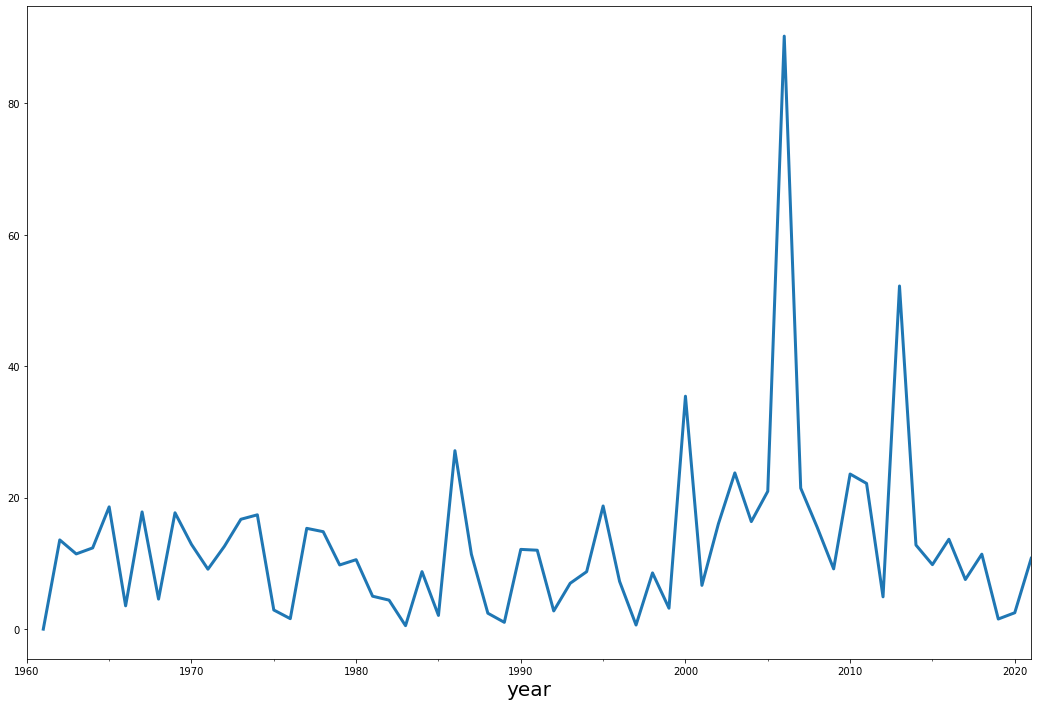

In [143]:
data["GDP_vol"] = data.GDP.pct_change(1).mul(100).abs()

data["GDP_vol"].plot()
plt.show()


In [144]:
train_df = data.iloc[:-3]
test_df = data.iloc[-3:]


In [145]:
smodel = pm.auto_arima(
    train_df.GDP_vol.dropna(),
    start_p=1,
    d=2,
    start_q=1,
    max_p=10,
    max_q=10,
    test="adf",
    error_action="ignore",
    trace=True,
)

smodel.summary()


Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=549.142, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=519.806, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=505.558, Time=0.05 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=498.198, Time=0.08 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=493.179, Time=0.10 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=493.263, Time=0.11 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=0.34 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=0.40 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=495.134, Time=0.19 sec

Best model:  ARIMA(4,2,0)(0,0,0)[0]          
Total fit time: 1.801 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   58
Model:               SARIMAX(4, 2, 0)   Log Likelihood                -241.590
Date:                Tue, 23 May 2023   AIC                            493.179
Time:                        07:13:56   BIC                            503.306
Sample:                    01-01-1961   HQIC                           497.105
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3331      0.092    -14.448      0.000      -1.514      -1.152
ar.L2         -1.2093      0.186     -6.510      0.000      -1.573      -0.845
ar.L3         -0.8089      0.278     -2.906      0.004      -1.354      -0.263
ar.L4         -0.3484      0.158     -2.198      0.028      -0.659      -0.038
sigma2       314.6047     43.884      7.169      0.000     228.593     400.616
===================================================================================
Ljung-Box (L1) (Q):                   0.35   Jarque-Bera (JB):                78.06
Prob(Q):                              0.55   Prob(JB):                         0.00
Heteroskedasticity (H):              12.41   Skew:                             1.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [146]:
test = adfuller(train_df.GDP_vol[1:])
print("adf: ", test[0])
print("p-value: ", test[1])
print("Critical values: ", test[4])
if test[0] > test[4]["5%"]:
    print("ряд нестационарен")
else:
    print("ряд стационарен")


adf:  -6.816105099260228
p-value:  2.0572875762632108e-09
Critical values:  {'1%': -3.5506699942762414, '5%': -2.913766394626147, '10%': -2.5946240473991997}
ряд стационарен


In [147]:
garch_df = pd.DataFrame(data["GDP_vol"].loc[data.index])
garch_df.loc[train_df.index, "GDP_vol"] = train_df["GDP_vol"].dropna()


In [148]:
model = arch_model(garch_df["GDP_vol"].dropna(), p=7, q=0, vol='GARCH')
model_results = model.fit(last_obs=test_df.index[0], update_freq=5)
model_results.summary()


Iteration:      5,   Func. Count:     55,   Neg. LLF: 218.07385504443658
Iteration:     10,   Func. Count:    106,   Neg. LLF: 217.6793039616613
Iteration:     15,   Func. Count:    157,   Neg. LLF: 16718.569791262475
Iteration:     20,   Func. Count:    211,   Neg. LLF: 214.73651734768475
Iteration:     25,   Func. Count:    260,   Neg. LLF: 214.73503182716945
Optimization terminated successfully    (Exit mode 0)
            Current function value: 214.7350318271728
            Iterations: 25
            Function evaluations: 260
            Gradient evaluations: 25


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                GDP_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -214.735
Distribution:                  Normal   AIC:                           447.470
Method:            Maximum Likelihood   BIC:                           466.014
                                        No. Observations:                   58
Date:                Tue, May 23 2023   Df Residuals:                       57
Time:                        07:13:57   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            11.7886      1.335      8.832  1.029e-18 [  9.172, 14.405]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega         45.3538     14.073      3.223  1.269e-03      [ 17.772, 72.936]
alpha[1]       0.0000  4.256e-02      0.000      1.000 [-8.342e-02,8.342e-02]
alpha[2]       0.0000  1.346e-02      0.000      1.000 [-2.637e-02,2.637e-02]
alpha[3]       0.0000  2.891e-02      0.000      1.000 [-5.666e-02,5.666e-02]
alpha[4]   3.4298e-03  4.845e-03      0.708      0.479 [-6.067e-03,1.293e-02]
alpha[5]       0.0000  8.855e-03      0.000      1.000 [-1.735e-02,1.735e-02]
alpha[6]       0.7280      0.481      1.514      0.130      [ -0.214,  1.670]
alpha[7]       0.1023  5.785e-02      1.768  7.713e-02   [-1.113e-02,  0.216]
=============================================================================

Covariance estimator: robust
"""

In [149]:
predictions_df = test_df.copy()
predictions_df["Predictions"] = model_results.forecast(
).residual_variance.loc[test_df.index]


In [150]:
predictions_df


,GDP,GDP_vol,Predictions
year,,,
2019-01-01,6.833754e+10,1.542746,213.267340
2020-01-01,7.004320e+10,2.495937,48.358726
2021-01-01,7.759428e+10,10.780603,48.356194


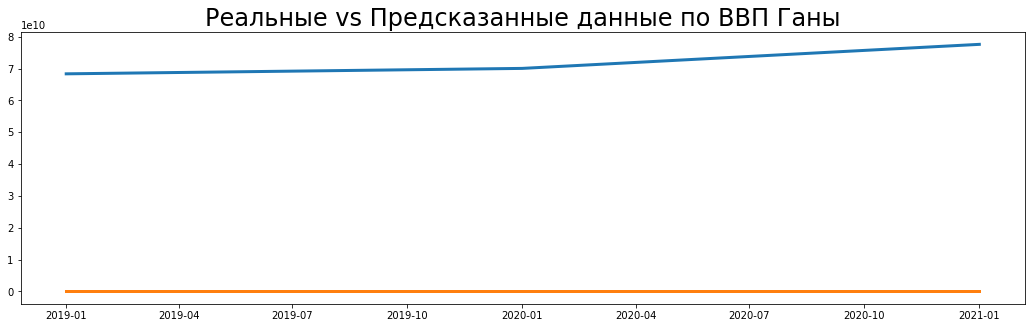

In [151]:
plt.rcParams["figure.figsize"] = 18, 5

plt.plot(predictions_df["GDP"].abs())
plt.plot(predictions_df["Predictions"])
plt.title("Реальные vs Предсказанные данные по ВВП Ганы", size=24)
plt.show()
